In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn-talk')
from matplotlib import cm
import numpy as np
import os
import scipy.io
import seaborn as sb
from scipy.fftpack import fft
import csv
import pandas as pd
from scipy.signal import butter, filtfilt
import glob
import seaborn as sns
import scikit_posthocs as sp
from scipy import signal

In [2]:
# Pathways
outpath = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\chunking'
figpath = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\chunking\figures'
source = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Centroids_Final\Raw_NG'

In [8]:
#sample data such that there are no NaNs within each path and that each path is greater than 100 frames (fft cannot tolerate NaNs, is removing better than smoothening?)
def removeNaN(df): 
    if np.any(df.X_position.isnull()):
        a = np.asarray(np.where(df.X_position.isnull())).ravel()
        b = a[1:]
        c = a[:-1]
        d = b-c
        last_chunk = len(df.X_position) - a[-1]


        if last_chunk > 100:

            start = a[-1]+1
            end = a[-1] + last_chunk-1

        elif a[0] > 100:
            start = 0
            end = a[0]-1


        elif d.max() > 100:
            e = d.argmax()
            start = a[e]+1
            end = a[e+1]-1

        else:
            print('error')
    
        x_no_nan = df.X_position.values[start:end]
        y_no_nan = df.Y_position.values[start:end]
        return(x_no_nan, y_no_nan)
    else:
        x = df.X_position.values
        y = df.Y_position.values
        return(x,y)

In [501]:
def rotation_matrix(x_0,y_0,x_1,y_1):
    
    A = np.asarray([(x_1-x_0), (y_1-y_0)]) # < --- is this counting the point as [(0,0), ((x_1-x_0), (y_1-y_0))] or [(x_1-x0), (y_1-y0)]?
    B = np.asarray([1,0])
    
    theta = np.arccos(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))
    
    if (y_1-y_0) < 0:
        theta += np.pi
    
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(( ( c,-s ) ,
                   ( s,c )  ))
    
    # do I have to shift the points too? so first point becomes origin, and then last point is shifted by the x & y of the first point. This is only used to find magnitude. Rotation matrix angle should hold for other points? each point as a vector with the origin and I rotate all those vectors equally
    
    return(R)

In [493]:
np.cos(270*np.pi/180)

-1.8369701987210297e-16

In [491]:
np.cos(0), np.cos(30*np.pi/180), np.cos(60*np.pi/180), np.cos(90*np.pi/180), np.cos(135*np.pi/180), np.cos(180*np.pi/180)

(1.0,
 0.8660254037844387,
 0.7071067811865476,
 0.5000000000000001,
 6.123233995736766e-17,
 -0.7071067811865475,
 -1.0)

In [391]:
x_0,y_0 = 0,0
x_1,y_1 = 2*np.sqrt(3)/2,2*1/2
A = np.asarray([(x_1-x_0), (y_1-y_0)])
B = np.asarray([1,0])

In [392]:
np.linalg.norm(A)

1.9999999999999998

In [395]:
np.arccos(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))*180/np.pi

29.999999999999993

In [375]:
np.dot(A,A)

25

In [373]:
np.linalg.norm(A)

5.0

In [292]:
R = rotation_matrix(0,0,10,10)
C = (1,2)
c = R.dot(C) # dont use dot product. Instead try using matrix multiplication??
c

array([-0.70710678,  2.12132034])

In [592]:
#Create a sliding window (10 wingbeats@25Hz/wingbeat&100frames/s ---> 40 frame window)
#report every distance vs displacement ratio for each chunk
def tortuosity_ratio(x,y,chunk):
    
    n = np.arange(0,len(x)-chunk,1)
    ratio_list = []
    
    
    for element in n[:140]:
        
        rotated_points = []
        raw_points = []
        shortest_path = np.sqrt((x[element+chunk]-x[element])**2 + (y[element+chunk]-y[element])**2)
        
        
        
        #generate rotation matrix
        
        R = rotation_matrix(x[element], y[element], x[element+chunk], y[element+chunk])
        
        
        actual_list = 0
        i = 0
        while i < len(x[element:element+chunk]):



            actual_path = np.sqrt((x[element:element+chunk+1][i+1]-x[element:element+chunk+1][i])**2 + (y[element:element+chunk+1][i+1]-y[element:element+chunk+1][i])**2)
            actual_list += actual_path

            
            #apply rotation matrix to every point


            C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
            C_rot = R.dot(C)
            raw_points.append(C)
            rotated_points.append(C_rot)
            

            i +=1
        
        #should account for last point, there has to be more efficient way to do this 
        
        
        C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
        C_rot = R.dot(C)
        raw_points.append(C)
        rotated_points.append(C_rot)
        
        ratio = actual_list/shortest_path
        ratio_list.append(ratio)
        
        mean = np.mean(ratio_list)
        std = np.std(ratio_list)
    return(mean, std, ratio_list, rotated_points, raw_points)

In [593]:
df = pd.read_csv(source + '\Centroids_Final_Sham_2_58256.csv')

In [594]:
x,y = removeNaN(df)
mean, std, ratio_list, rotated_points, raw_points = tortuosity_ratio(x,y, 40)
len(x)

256

In [595]:
x_rotated = []
y_rotated = []
for e in rotated_points:
    x_rotated.append(e[0])
    y_rotated.append(e[1])
x_raw = []
y_raw = []
for e in raw_points:
    x_raw.append(e[0])
    y_raw.append(e[1])


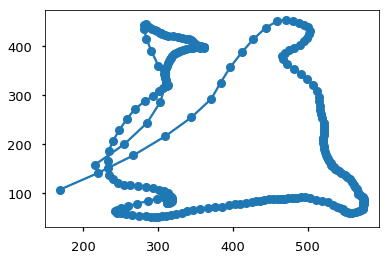

In [596]:
plt.plot(x,y, "-o")

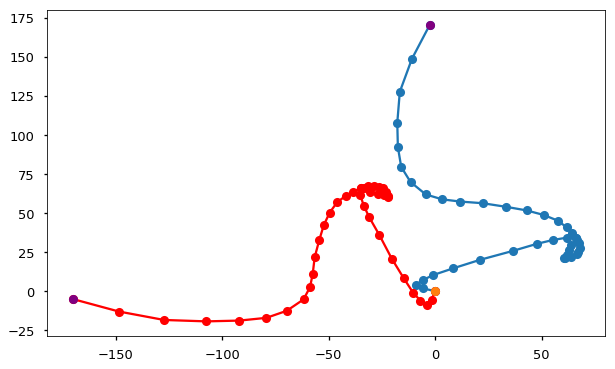

In [597]:
plt.figure(figsize=(10,6))
plt.plot(x_raw[0:], y_raw[0:], "-o")
plt.plot(x_rotated[0:],y_rotated[0:], "-o", c = 'r')
plt.plot(x_raw[0], y_raw[0], "-o")
plt.plot(x_raw[-1], y_raw[-1], "-o", c = "purple")
plt.plot(x_rotated[-1], y_rotated[-1], "-o", c = "purple")

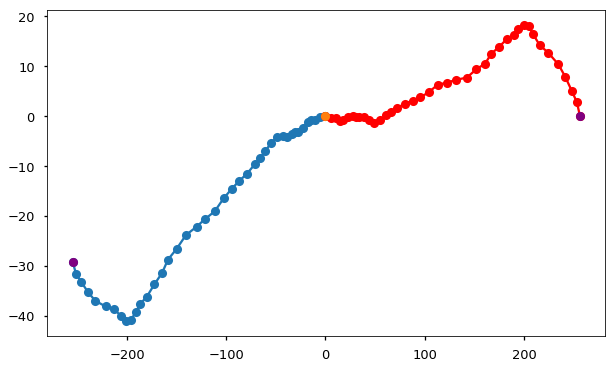

In [479]:
plt.figure(figsize=(10,6))
plt.plot(x_raw[0:], y_raw[0:], "-o")
plt.plot(x_rotated[0:],y_rotated[0:], "-o", c = 'r')
plt.plot(x_raw[0], y_raw[0], "-o")
plt.plot(x_raw[-1], y_raw[-1], "-o", c = "purple")
plt.plot(x_rotated[-1], y_rotated[-1], "-o", c = "purple")

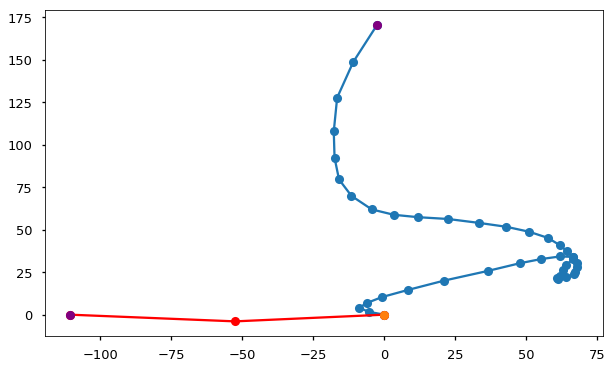

In [574]:
plt.figure(figsize=(10,6))
plt.plot(x_raw[0:], y_raw[0:], "-o")
plt.plot(x_rotated[0:],y_rotated[0:], "-o", c = 'r')
plt.plot(x_raw[0], y_raw[0], "-o")
plt.plot(x_raw[-1], y_raw[-1], "-o", c = "purple")
plt.plot(x_rotated[-1], y_rotated[-1], "-o", c = "purple")
#why isnt this level?

In [598]:
y_rotated[0], y_rotated[-1]

(0.0, -5.005406250039132)

In [562]:
x_rotated[0]-x_rotated[-1], rotated

(170.3143987308616, 170.38793533223776)

In [600]:
np.arccos((x_rotated[0]-x_rotated[-1])/rotated)*180/np.pi # looks like my roation is 10 degrees off (is this conserved? <-- no its not)

1.6833933528157976

In [533]:
y_raw[-1]-y_raw[0],x_rotated[-1]-x_rotated[0] # not actual distance tho, cause this wasn't rotated 90 deg

(75.85965390000001, -74.95345086147175)

In [599]:
raw = np.sqrt((y_raw[-1]-y_raw[0])**2 + (x_raw[-1]-x_raw[0])**2)
rotated = np.sqrt((y_rotated[-1]-y_rotated[0])**2 + (x_rotated[-1]-x_rotated[0])**2)
raw, rotated

(170.38793533223776, 170.38793533223776)

In [5]:
#rotate the data such that the variance from the shortest path is in one dimension

In [6]:
#calculate an fft spectrum 

In [7]:
#average the spectrum across each chunk within a path (considering both the mean and the variance)

In [588]:
chunk = 40
n = np.arange(0,len(x)-chunk,1)
ratio_list = []

angle_list = []

for element in n:

    rotated_points = []
    raw_points = []
    shortest_path = np.sqrt((x[element+chunk]-x[element])**2 + (y[element+chunk]-y[element])**2)



    #generate rotation matrix

    R = rotation_matrix(x[element], y[element], x[element+chunk], y[element+chunk])


    actual_list = 0
    i = 0
    while i < len(x[element:element+chunk]):



        actual_path = np.sqrt((x[element:element+chunk+1][i+1]-x[element:element+chunk+1][i])**2 + (y[element:element+chunk+1][i+1]-y[element:element+chunk+1][i])**2)
        actual_list += actual_path


        #apply rotation matrix to every point


        C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
        C_rot = R.dot(C)
        raw_points.append(C)
        rotated_points.append(C_rot)


        i +=1

    #should account for last point, there has to be more efficient way to do this 


    C = ((x[element:element+chunk+1][i]-x[element:element+chunk+1][0]), (y[element:element+chunk+1][i]-y[element:element+chunk+1][0]))
    C_rot = R.dot(C)
    raw_points.append(C)
    rotated_points.append(C_rot)
    
    
    x_rotated = []
    y_rotated = []
    for e in rotated_points:
        x_rotated.append(e[0])
        y_rotated.append(e[1])
    
    rotated = np.sqrt((y_rotated[-1]-y_rotated[0])**2 + (x_rotated[-1]-x_rotated[0])**2)
    
    
    
    angle_list.append(np.arccos((x_rotated[0]-x_rotated[-1])/rotated)*180/np.pi)

    ratio = actual_list/shortest_path
    ratio_list.append(ratio)

    mean = np.mean(ratio_list)
    std = np.std(ratio_list)

In [602]:
angle_list

[139.75041812843205,
 146.82478419295154,
 158.7095423989353,
 178.5994840233248,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 179.7026851512049,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 179.9183948810796,
 178.0913524479711,
 176.5349566469885,
 175.98314628344423,
 177.12292129671087,
 179.73587288897696,
 0.0,
 0.0,
 0.0,
 0.0,
 179.78252315790942,
 175.82954372206004,
 171.29167774622871,
 163.39170624591188,
 152.2594650651527,
 139.7275780569269,
 126.1850573810